In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.layers import Conv2D, MaxPooling2D, 

import os
import matplotlib.pyplot as plt
AUTO = tf.data.AUTOTUNE

In [3]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2025-02-08 18:58:36.486702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2446 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-02-08 18:58:36.487190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22214 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [4]:
base_dir = '../ML Research/ILSVRC/Data/CLS-LOC'
train_dir = os.path.join(base_dir, 'train/')
val_dir = os.path.join(base_dir, 'val/')
test_dir = os.path.join(base_dir, 'test/')

## ImageNet Dataset Creation:

In [5]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

In [6]:
def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.resize(image, (160, 160))

    grayscale = rgb_to_grayscale(image)
    
    grayscale = (grayscale / 127.5) - 1
    image = (image / 127.5) - 1

    return grayscale, image

In [7]:
os.listdir(test_dir)[:5]

['ILSVRC2012_test_00022959.JPEG',
 'ILSVRC2012_test_00071972.JPEG',
 'ILSVRC2012_test_00000824.JPEG',
 'ILSVRC2012_test_00045324.JPEG',
 'ILSVRC2012_test_00081438.JPEG']

In [20]:
def get_dataset(path, batch_size):
    if (path.split('/')[-2] == "test"):
        image_paths = tf.data.Dataset.list_files(path + "*.JPEG", shuffle=True)
    else:
        image_paths = tf.data.Dataset.list_files(path + "*/*.JPEG", shuffle=True)
    dataset = image_paths.map(process_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size).prefetch(AUTO)
    return dataset

In [21]:
train_data = get_dataset(train_dir, batch_size=BATCH_SIZE)

In [25]:
train_data.cardinality().numpy() * BATCH_SIZE

1281280

In [26]:
val_data = get_dataset(val_dir, batch_size=BATCH_SIZE)

In [27]:
val_data.cardinality().numpy() * BATCH_SIZE

50176

In [22]:
test_data = get_dataset(test_dir, batch_size=BATCH_SIZE)

In [24]:
test_data.cardinality().numpy()

391

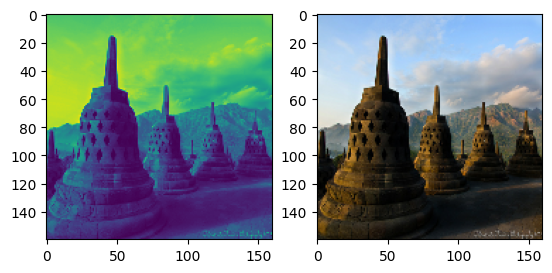

In [71]:
for batch in test_data.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(batch[0][0] / 255)
    axs[1].imshow(batch[1][0] / 255)
    break

## Model Experimentation:

In [28]:
class encoder_block(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=(3, 3), pool_size=2):
        super(encoder_block, self).__init__()
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")
        self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")
        self.max_pool = MaxPooling2D(pool_size=pool_size)

    def call(self, inputs):
        x = self.conv_1(inputs)
        skip = self.conv_2(x)
        output = self.max_pool(skip)

        return skip, output

In [ ]:
class decoder_block(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=(3, 3), pool_size=2